In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5395,00029143_000.png,No Finding,0,29143,052Y,F,AP,3056,2544,0.139,0.139
2611,00013112_001.png,No Finding,1,13112,050Y,F,PA,2992,2991,0.143,0.143
3251,00016051_023.png,No Finding,23,16051,030Y,F,PA,2862,2785,0.143,0.143


In [4]:
## EDA
# Todo 
label=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

for x in label:
    if len(x)>1:
        all_xray_df[x] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if x in finding else 0)

        
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


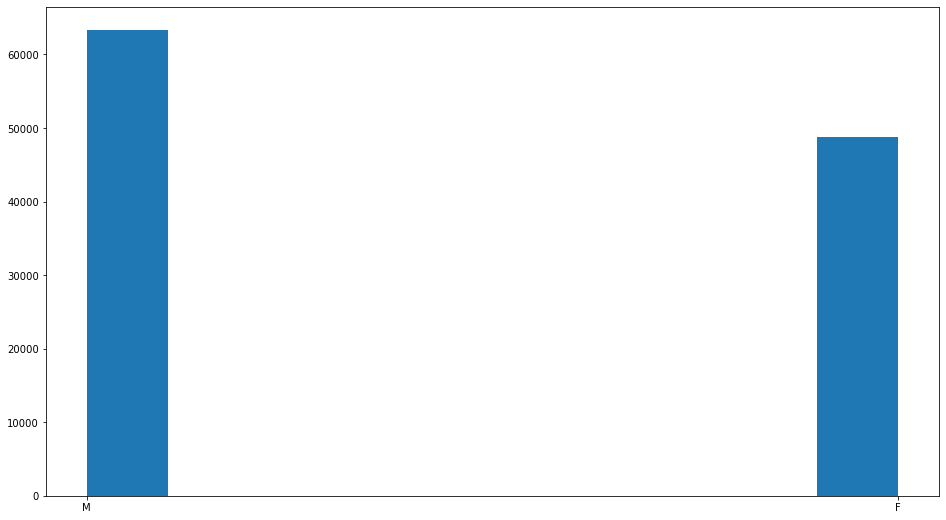

In [5]:
plt.figure(figsize=(16,9))
plt.hist(all_xray_df['Patient Gender'])
plt.show()

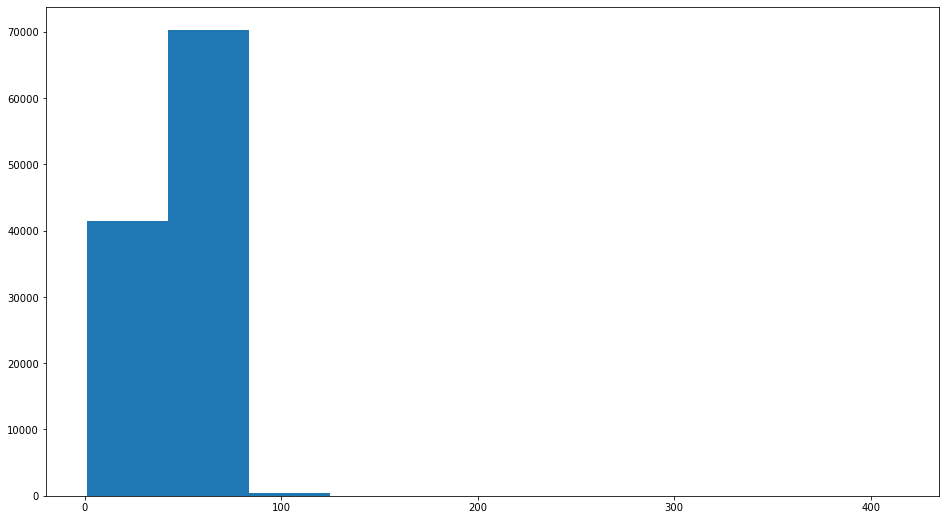

46.90146271851587


In [6]:
plt.figure(figsize=(16,9))
plt.hist(all_xray_df['Patient Age'], 10)
plt.show()
print(all_xray_df['Patient Age'].mean())
      

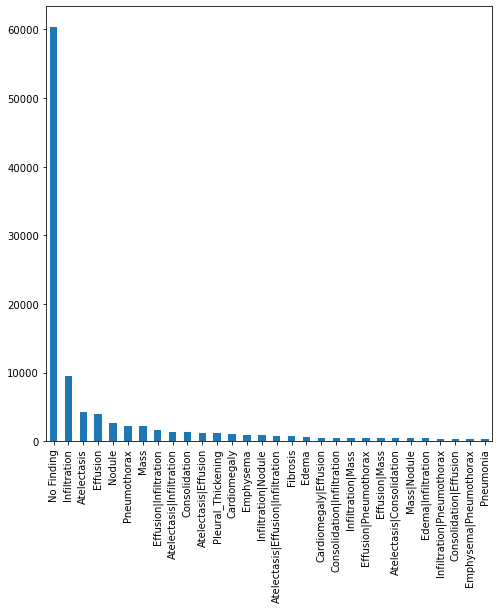

In [7]:
plt.figure(figsize=(8,8))
all_xray_df['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [8]:
PA=all_xray_df['View Position'][all_xray_df['View Position']=='PA']
AP=all_xray_df['View Position'][all_xray_df['View Position']=='AP']
print('Posterior-Anterior: ' + str(PA.value_counts()))
print('Anterior-Posterior: ' + str(AP.value_counts()))

Posterior-Anterior: PA    67310
Name: View Position, dtype: int64
Anterior-Posterior: AP    44810
Name: View Position, dtype: int64


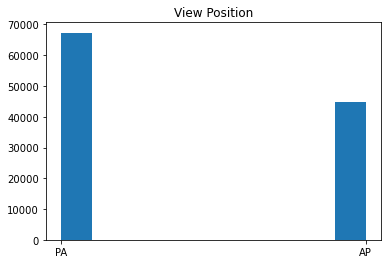

In [9]:
plt.hist(all_xray_df['View Position'])
plt.title('View Position')
plt.show()

In [10]:
len(all_xray_df[all_xray_df['Finding Labels'] == 'Pneumonia'])


322

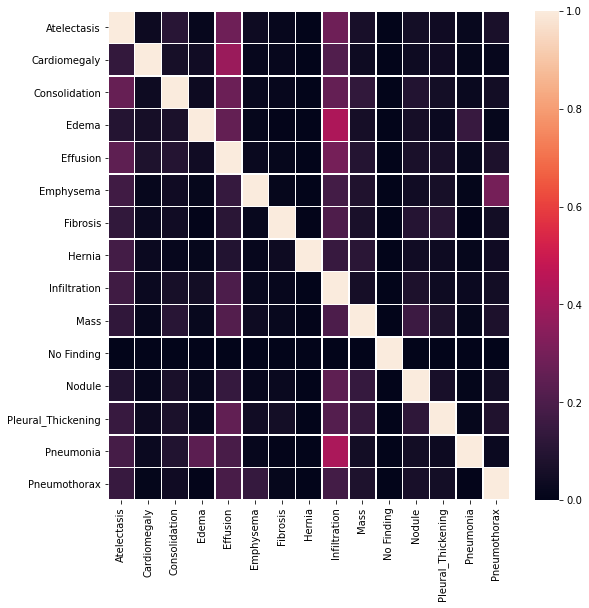

In [14]:
n_p = len(all_xray_df)

#n_findings
n_f = len(label)

arr = np.zeros((n_f, n_f))

for i in range(n_f):
    f_a = label[i]
    for j in range(n_f):
        f_b = label[j]
        
        if f_a == f_b:
            arr[i, j] = 1
            continue
        
        records = all_xray_df[all_xray_df[f_a] == 1.0]
        co_f_a_b = ((100 * np.sum(records[f_b])) / len(records)) / 100 # turn to 100% then to [0-1]
        arr[i,j] = co_f_a_b

plt.figure(figsize=(9,9))
ax = sns.heatmap(arr, linewidth=0.5, xticklabels = label, yticklabels = label)
plt.show()

Observations


The dataset seems to have a fairly spread out range among patient ages. The average age is 45 years, with a high number of patients approximately between 50-75.  There are more males in the dataset than females. However, there are still over 5000 scannings of female patients too, so the dataset is not completely oriented to one single gender. A majority of the dataset contains no findings. This might make it hard for us too study pneumonia. Nonetheless, it provides an accurate estimation of what we will find in a real scenario. Furthermore, there are slightly more post-anterior images than anterior-posterior. And a total of 322 images with pneumonia in all_xray_df. Finally, from the heat map, we can conclude that pneumonia is sometimes found along with other diseases. A prominent one being infiltration. 
